In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [18]:
#Import the libraries
import pandas as pd
from matplotlib import pyplot
import glob
import numpy as np
import math as mt
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import lognorm
from scipy.stats import norm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.axes_divider import make_axes_area_auto_adjustable
from scipy.signal import chirp, find_peaks, peak_widths,find_peaks_cwt

In [41]:
#Define diretory
datadir = '/home/jovyan/Article_review/Data'

#Define Year for processing
Year = str(2021)
#exemple file name: array_T_data_2020_150_350.csv

data_temp = sorted(glob.glob(datadir+'/*array_T_data_'+Year+'_150_350.csv'))

# Read the CSV file
temperature_data = pd.read_csv(data_temp[0])

In [42]:
#Bimodal gausssian function
def gaussian_bimodal(x, amplitude1, mean1, std1, amplitude2, mean2, std2):
    #Lock the second curve based on the literature
    mean2 = 6.90
    std2 = 0.18
    return (amplitude1 * np.exp(-(x - mean1) ** 2 / (2 * std1 ** 2)) +
            amplitude2 * np.exp(-(x - mean2) ** 2 / (2 * std2 ** 2)))

In [43]:
#Gaussian function
def gaussian(x, amplitude1, mean1, std1):
    return amplitude1 * np.exp(-(x - mean1) ** 2 / (2 * std1 ** 2))

In [44]:
#Function to plot a graph of distribuiton of temperatures of the fires in natural logarithm and fit gausssian curves
def plot_Temp_log_bimodal_fit(Temp_data,filename):
    #List the data file header
    header = list(Temp_data)

    #Extract the columns of the file
    pos1=header.index('array_temp')
    column1=Temp_data.iloc[:,pos1]
    Temp = np.array(column1.dropna(), dtype=float)

    #Exclude the data below the 400K threshold and apply the logarithm
    Temp=Temp[Temp>400]
    Temp = np.log(Temp)


    #Separate the data above and below the flamming threshold (~800K)
    data1 = Temp[Temp<=6.68]
    data2 = Temp[Temp>6.68]
    data = np.concatenate([data1, data2])


    #Calculate the relative frequency (the automatic plot in np.histogram for relative frequency does not work with logarithmic data)
    relative_freq = data / len(data)

    #Create a histogram with relative frequency
    num_bins = 200
    hist, bin_edges = np.histogram(data, bins=num_bins, range=(min(data), max(data)), weights=relative_freq)


    #Calculate the bin centers to use as a x-coordinate value
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Define the initial parameter for the bimodal fit
    amplitude2_initial = np.max(data2)
    mean2_initial = 6.90
    std2_initial = 0.18

    parameters_initial = [np.max(hist), np.mean(data1), np.std(data1),
                            amplitude2_initial, mean2_initial, std2_initial]

    parameters_optimized, _ = curve_fit(gaussian_bimodal, bin_centers, hist, p0=parameters_initial)

    # Optimize parameters
    amplitude1_optimized, mean1_optimized, std1_optimized, amplitude2_optimized, mean2_optimized, std2_optimized = parameters_optimized

    fig = pyplot.figure(figsize=(8, 6))

    # Configure the plot
    x_curve = np.linspace(min(data), max(data), 1000)
    y_curve = gaussian_bimodal(x_curve, amplitude1_optimized, mean1_optimized, std1_optimized,
                                amplitude2_optimized, mean2_optimized, std2_optimized)
    Label = 'N_total = {:.0f}\nσ1={:.2f},σ2={:.2f}\nMode_1={:.2f},Mode_2={:.2f}'.format(len(Temp),std1_optimized,std2_optimized,mean1_optimized,mean2_optimized)
    pyplot.hist(data, bins=num_bins, range=(min(data), max(data)), weights=relative_freq, alpha=0.6, label=Label,color='gray')
    pyplot.plot(x_curve, y_curve, label='Bimodal fit',color='0.0')

    # Plot individual fits
    x_curve_individual = np.linspace(min(data), max(data), 1000)
    y_curve_individual_1 = gaussian(x_curve_individual, amplitude1_optimized, mean1_optimized, std1_optimized)
    y_curve_individual_2 = gaussian(x_curve_individual, amplitude2_optimized, mean2_optimized, std2_optimized)

    pyplot.plot(x_curve_individual, y_curve_individual_1,'--', label='Smoldering phase fit',color='0.5')
    pyplot.plot(x_curve_individual, y_curve_individual_2,'-.',label='Flaming phase fit',color='0.2')

    # Configure the xticks with 0.5
    pyplot.xticks(np.arange(6, 8.5, 0.5))

    pyplot.title(Year)
    pyplot.xlabel('ln(T/T0)')
    pyplot.ylabel('Relative frequency')
    pyplot.legend()
    pyplot.grid()
    pyplot.tight_layout()

    # Save graph
    pyplot.savefig(filename+'.png',dpi=300)

    # Exponentiate the values to get the actual (non-logarithmic) values
    mean1_optimized_exp = np.exp(mean1_optimized)  # Exponentiate mean1
    mean2_optimized_exp = np.exp(mean2_optimized)  # Exponentiate mean2
    
    # Calculate the lower and upper bounds for the means using 1 standard deviation
    mean1_lower = mean1_optimized - std1_optimized
    mean1_upper = mean1_optimized + std1_optimized
    mean2_lower = mean2_optimized - std2_optimized
    mean2_upper = mean2_optimized + std2_optimized

    # Exponentiate the values to get the actual (non-logarithmic) values
    mean1_lower_exp = np.abs(mean1_optimized_exp - np.exp(mean1_lower))  # Exponentiate lower mean1
    mean1_upper_exp = np.abs(mean1_optimized_exp - np.exp(mean1_upper)) # Exponentiate upper mean1
    mean2_lower_exp = np.abs(mean2_optimized_exp - np.exp(mean2_lower))  # Exponentiate lower mean2
    mean2_upper_exp = np.abs(mean2_optimized_exp - np.exp(mean2_upper))
    
    # Format the label to include the means and their bounds
    Label = ('N_total = {:.0f}\n'
             'σ1={:.2f} (Lower: {:.2f}, Upper: {:.2f}), '
             'σ2={:.2f} (Lower: {:.2f}, Upper: {:.2f})\n'
             'Mode_1={:.2f}, Mode_2={:.2f}'.format(
        len(Temp), 
        std1_optimized, mean1_lower_exp, mean1_upper_exp,  # Show mean1 with std bounds
        std2_optimized, mean2_lower_exp, mean2_upper_exp,  # Show mean2 with std bounds
        mean1_optimized_exp, mean2_optimized_exp  # Actual means
    ))
    
    print(Label)

    return

/tmp/ipykernel_409/611153117.py:41: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters_optimized, _ = curve_fit(gaussian_bimodal, bin_centers, hist, p0=parameters_initial)


N_total = 100461
σ1=0.23 (Lower: 114.90, Upper: 144.67), σ2=0.18 (Lower: 163.46, Upper: 195.69)
Mode_1=558.36, Mode_2=992.27


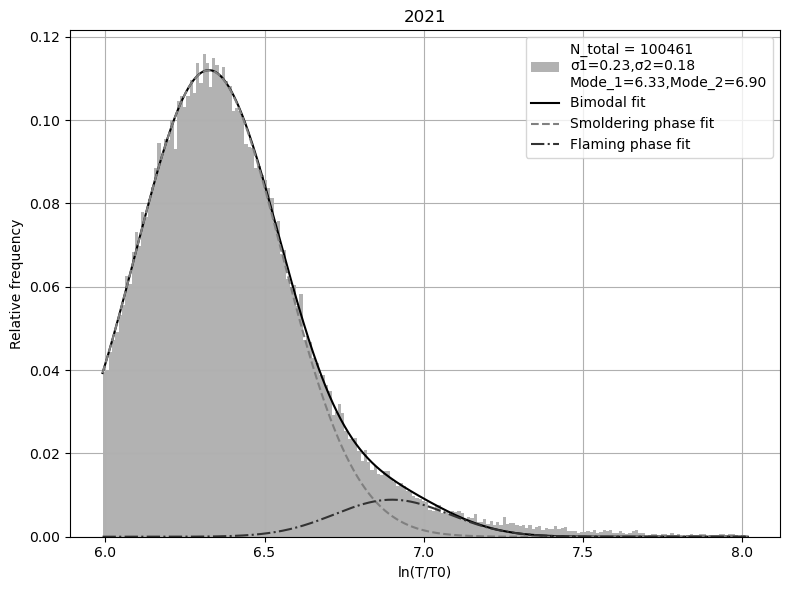

In [45]:
plot_Temp_log_bimodal_fit(temperature_data,'Bimodal_fit_temperature_data_'+Year)